In [1]:
import openpyxl
import pandas as pd

In [2]:
# Open an existing workbook
workbook = openpyxl.load_workbook(r'C:\Users\ricca\OneDrive\Desktop\Executive_Education_Imperial\25.capstone\data_capstone_project.xlsx')



# Datasheet Template
 

## Motivation

Valuation techniques always played a central role in practitioners’ decisions: financial analysts try to judge the attractiveness of a specific company and to propose investment ideas analysing financial statements. Financial ratios related to fundamental analysis have a significant impact on investors’ perception of investments. Several factors are responsible for the variations of the above-mentioned metrics and a significant amount of paper about this topic has been written (see, eg, Damodaran (2012) and Rekhi, Ward, Wei (2014)).

Combining multiples valuation and statistical methods controlling for determinants of the ratios, does let to find “truly” undervalued companies? This paper is an attempt to identify the major determinants of variations of financial ratios on the American market using linear and non-linear models.

Specifically, we are considering Price to Book Multiple to perform OLS regressions, logit regressions,K-NN cluster identifier, Random Forest (improved with Bayesian Optimization) algorithms considering the Russell 3000 Index starting from the year 1989 to the year 2019.

The dataset was scraped from Datastream Refinitiv Eikon, cleaned from outliers and from NAN variables. Moreover, it was scaled and organized in different sheets. For the Capstone Project, I focused on Price to Book multiple and its relationship with ROE (return on equity, is the measure of a company’s annual return (net income) divided by the value of its total shareholders’ equity, expressed as a percentage), EPS (Earnings per share are a t+2 forecast proxy, generated as a mean among financial analysts), BETA (Beta is the historical variable referring to the risk of the company).  

Befored to run the analysis were implemented preprocessing tasks such as scaling, computes descriptive statistics, explores correlations between variables, checks for multicollinearity, and visualizes the data through scatter plots, boxplots, and histograms. It's a comprehensive EDA process that helps in understanding the characteristics of the dataset before building a machine learning model.


                 PB           ROE           EPS          BETA
count  2.757300e+04  2.757300e+04  2.757300e+04  2.757300e+04
mean   1.286664e-15  2.360558e-15 -3.157168e-17 -2.807910e-16
std    1.000018e+00  1.000018e+00  1.000018e+00  1.000018e+00
min   -9.094139e-01 -1.350634e+00 -5.459969e-01 -5.069861e+01
25%   -4.826416e-01 -6.067779e-01 -3.678516e-01 -5.549608e-01
50%   -2.646499e-01 -2.253767e-01 -2.060874e-01 -8.825589e-02
75%    1.314194e-01  3.108914e-01  4.986850e-02  4.401698e-01
max    2.549828e+01  6.869674e+00  1.964995e+01  3.402253e+01
            PB       ROE       EPS      BETA
PB    1.000000  0.547274  0.030063  0.040911
ROE   0.547274  1.000000  0.095803  0.025633
EPS   0.030063  0.095803  1.000000  0.003300
BETA  0.040911  0.025633  0.003300  1.000000


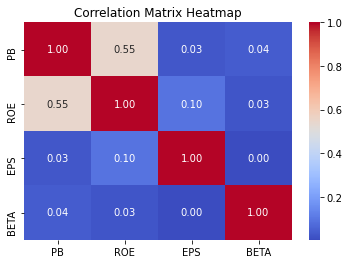

  Variable       VIF
0      ROE  1.009917
1      EPS  1.009264
2     BETA  1.000658


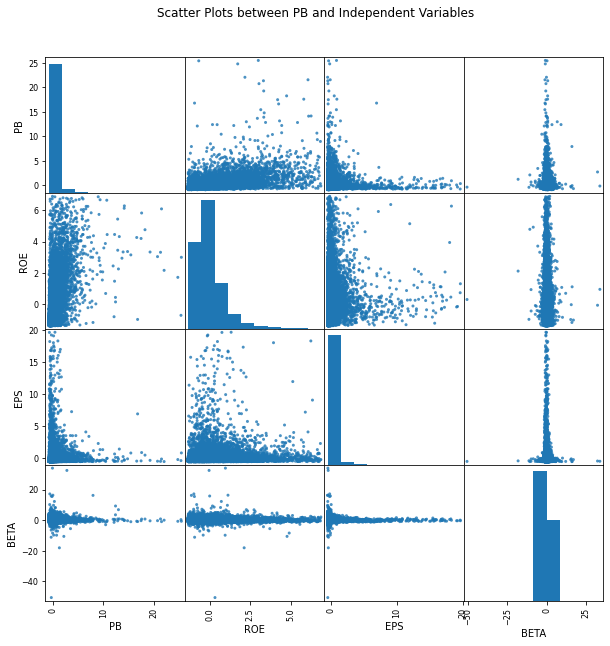

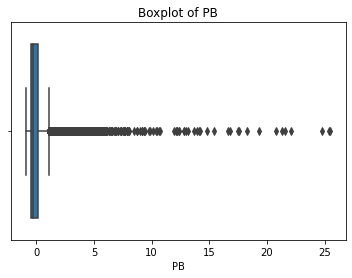

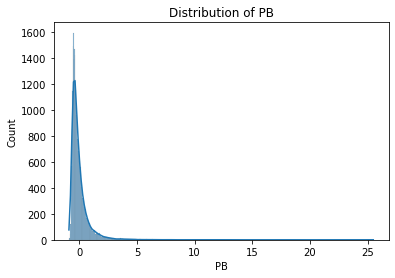

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler
from pandas.plotting import scatter_matrix
from scipy.stats.mstats import winsorize


# Load the data
df = pd.read_excel(r'C:\Users\ricca\OneDrive\Desktop\Executive_Education_Imperial\25.capstone\data_capstone_project.xlsx', sheet_name='PB')

# Drop the 'year' column
df = df.drop(columns=['year'])

# Separate features and target variable
features = ['ROE', 'EPS', 'BETA']
target = 'PB'

X = df[features]
y = df[target]

# Scale features and target variable using StandardScaler
scaler_X = StandardScaler()
scaler_y = StandardScaler()

X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.values.reshape(-1, 1)).flatten()

# Replace the original columns with the scaled ones
df[features] = X_scaled
df[target] = y_scaled

# Descriptive Statistics
descriptive_stats = df.describe()
print(descriptive_stats)

# Correlation Matrix
correlation_matrix = df.corr()
print(correlation_matrix)

# Correlation Matrix Heatmap
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix Heatmap')
plt.show()

# Multicollinearity Check (VIF)
vif_data = pd.DataFrame()
vif_data["Variable"] = features
vif_data["VIF"] = [variance_inflation_factor(X_scaled, i) for i in range(X_scaled.shape[1])]
print(vif_data)

# Scatter Plots
scatter_matrix(df, alpha=0.8, figsize=(10, 10), diagonal='hist')
plt.suptitle('Scatter Plots between PB and Independent Variables', y=0.95)
plt.show()

# Outlier Detection (Boxplot)
sns.boxplot(x=df[target])
plt.title(f'Boxplot of {target}')
plt.show()

# Distribution of Variables (Histogram)
sns.histplot(df[target], kde=True)
plt.title(f'Distribution of {target}')
plt.show()


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.290
Model:                            OLS   Adj. R-squared:                  0.290
Method:                 Least Squares   F-statistic:                     2632.
Date:                Sun, 17 Dec 2023   Prob (F-statistic):               0.00
Time:                        14:51:47   Log-Likelihood:                -24076.
No. Observations:               19301   AIC:                         4.816e+04
Df Residuals:                   19297   BIC:                         4.819e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const      -9.931e-17      0.006  -1.64e-14      1.0

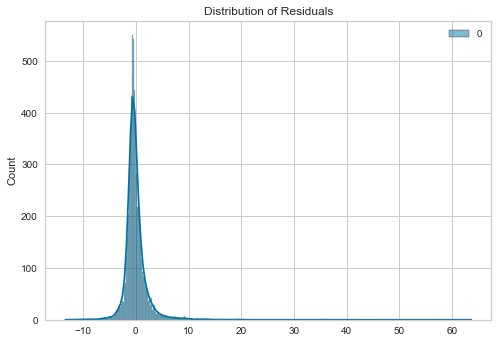

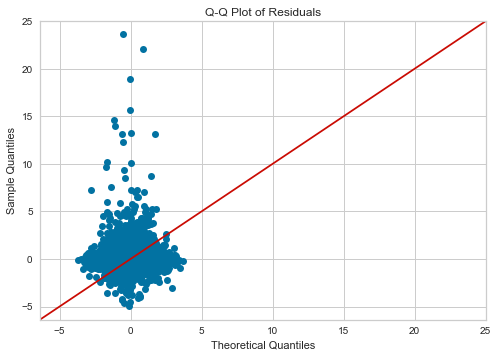

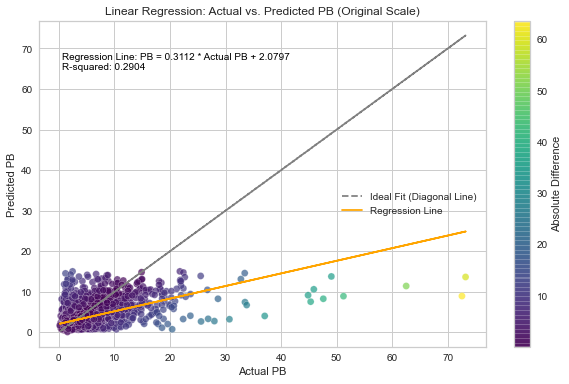

In [22]:
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# Load the data
df = pd.read_excel(r'C:\Users\ricca\OneDrive\Desktop\Executive_Education_Imperial\25.capstone\data_capstone_project.xlsx', sheet_name='PB')

# Sort the DataFrame chronologically
df.sort_values(by='year', inplace=True)

# Select features (independent variables) and target (dependent variable)
features = ['ROE', 'EPS', 'BETA']
target = 'PB'

# Extract features and target variable
X = df[features]
y = df[target]

# Split the data into a training set (70%) and a test set (30%)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Standardize both the features and the target variable
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scaler_y = StandardScaler()
y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1, 1)).flatten()
y_test_scaled = scaler_y.transform(y_test.values.reshape(-1, 1)).flatten()

# Add a constant term for intercept in the statsmodels model
X_train_sm = sm.add_constant(X_train_scaled)

# Create and train a linear regression model using statsmodels
model_sm = sm.OLS(y_train_scaled, X_train_sm).fit()

# Display regression summary
print(model_sm.summary())

# Make predictions on the standardized test set
X_test_scaled_sm = sm.add_constant(X_test_scaled)
y_pred_scaled = model_sm.predict(X_test_scaled_sm)

# Inverse transform the standardized predicted values to the original scale
y_pred_original_scale = scaler_y.inverse_transform(y_pred_scaled.reshape(-1, 1)).flatten()

# Reshape arrays for residuals
residuals = y_test.values.reshape(-1, 1) - y_pred_original_scale.reshape(-1, 1)

# Residual Analysis
sns.histplot(residuals, kde=True)
plt.title('Distribution of Residuals')
plt.show()

# Q-Q plot for normality check
sm.qqplot(residuals, line='45', fit=True)
plt.title('Q-Q Plot of Residuals')
plt.show()

# Plot predictions vs. actual values with a regression line and a diagonal line
plt.figure(figsize=(10, 6))

# Color the dots based on the absolute difference
abs_diff = np.abs(y_test - y_pred_original_scale)
scatter = plt.scatter(y_test, y_pred_original_scale, c=abs_diff, cmap='viridis', alpha=0.7, edgecolors='w')
plt.colorbar(scatter, label='Absolute Difference')

plt.plot(y_test, y_test, linestyle='--', color='gray', label='Ideal Fit (Diagonal Line)')

# Regression line
slope, intercept = np.polyfit(y_test, y_pred_original_scale, 1)
plt.plot(y_test, slope * y_test + intercept, color='orange', label='Regression Line')

plt.xlabel('Actual PB')
plt.ylabel('Predicted PB')
plt.title('Linear Regression: Actual vs. Predicted PB (Original Scale)')
plt.legend(loc='upper right', bbox_to_anchor=(1, 0.5))  # Move legend to the right

# Display the equation of the regression line and R-squared value
equation = (
    f'Regression Line: PB = {slope:.4f} * Actual PB + {intercept:.4f}\n'
    f'R-squared: {model_sm.rsquared:.4f}'
)
plt.annotate(equation, xy=(0.05, 0.85), xycoords='axes fraction', fontsize=10, color='black')

plt.show()


In [17]:
#logit
import pandas as pd
import statsmodels.api as sm
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score
import numpy as np

# Load the data
df = pd.read_excel(r'C:\Users\ricca\OneDrive\Desktop\Executive_Education_Imperial\25.capstone\data_capstone_project.xlsx', sheet_name='PB')

# Sort the DataFrame chronologically
df.sort_values(by='year', inplace=True)

# Calculate Z-scores for PB within each sector
df['PB_zscore'] = df.groupby('sector')['PB'].transform(lambda x: (x - x.mean()) / x.std())

# Set a Z-score threshold (0) and create the binary column
zscore_threshold = 0
df['PB_binary'] = (df['PB_zscore'] > zscore_threshold).astype(int)

# Drop the original 'year' column
df.drop('year', axis=1, inplace=True)

# Select features (independent variables) and target (dependent variable)
features = ['ROE', 'EPS', 'BETA', 'sector']
target = 'PB_binary'

# Standardize features using Z-scores
scaler = StandardScaler()
df[['ROE', 'EPS', 'BETA']] = scaler.fit_transform(df[['ROE', 'EPS', 'BETA']])

# Convert 'sector' to a categorical variable
df['sector'] = pd.Categorical(df['sector'])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Run logistic regression using statsmodels with categorical encoding for 'sector'
X_train_encoded = pd.get_dummies(X_train, columns=['sector'], drop_first=True)
X_test_encoded = pd.get_dummies(X_test, columns=['sector'], drop_first=True)

logit_model = sm.Logit(y_train, sm.add_constant(X_train_encoded))
result = logit_model.fit()

# Display regression results
print(result.summary())

# Make predictions on the test set
X_test_encoded = sm.add_constant(X_test_encoded)  # Add constant for predictions
y_pred = result.predict(X_test_encoded)
y_pred_binary = (y_pred > 0.5).astype(int)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred_binary)
classification_rep = classification_report(y_test, y_pred_binary)

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred_binary)
precision = precision_score(y_test, y_pred_binary)
recall = recall_score(y_test, y_pred_binary)

print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Optimization terminated successfully.
         Current function value: 0.507751
         Iterations 6
                           Logit Regression Results                           
Dep. Variable:              PB_binary   No. Observations:                22058
Model:                          Logit   Df Residuals:                    22044
Method:                           MLE   Df Model:                           13
Date:                Sun, 17 Dec 2023   Pseudo R-squ.:                  0.1931
Time:                        11:37:00   Log-Likelihood:                -11200.
converged:                       True   LL-Null:                       -13880.
Covariance Type:            nonrobust   LLR p-value:                     0.000
                                    coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------------------------
const                            -1.6221      0.273     -5.949      0.

In [18]:
#knn

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error

# Load the data
df = pd.read_excel(r'C:\Users\ricca\OneDrive\Desktop\Executive_Education_Imperial\25.capstone\data_capstone_project.xlsx', sheet_name='PB')

# Sort the DataFrame chronologically
df.sort_values(by='year', inplace=True)

# Calculate Z-scores for PB within each sector
df['PB_zscore'] = df.groupby('sector')['PB'].transform(lambda x: (x - x.mean()) / x.std())

# Set a Z-score threshold (0) and create the binary column
zscore_threshold = 0
df['PB_binary'] = (df['PB_zscore'] > zscore_threshold).astype(int)

# Drop the original 'year' column
df.drop('year', axis=1, inplace=True)

# Select features (independent variables) and target (dependent variable)
features = ['ROE', 'EPS', 'BETA', 'sector']
target = 'PB_binary'

# Separate numerical and categorical features
numeric_features = ['ROE', 'EPS', 'BETA']
categorical_features = ['sector']

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Initialize KNN classifier
knn = KNeighborsClassifier()

# Create a pipeline with preprocessing and KNN
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', knn)])

# Lists to store results
neighbors_list = []
rmse_list = []
misclassification_rate_list = []

# Evaluate different values of n_neighbors
for n_neighbors in range(2, 12):
    knn.set_params(n_neighbors=n_neighbors)
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    # Calculate RMSE
    rmse = mean_squared_error(y_test, y_pred, squared=False)
    rmse_list.append(rmse)

    # Calculate misclassification rate
    misclassification_rate = 1 - model.score(X_test, y_test)
    misclassification_rate_list.append(misclassification_rate)

    neighbors_list.append(n_neighbors)

    print(f"Number of Neighbors: {n_neighbors}, RMSE: {rmse:.4f}, Misclassification Rate: {misclassification_rate:.4f}")

# Choose the best n_neighbors based on the results
best_n_neighbors_index = rmse_list.index(min(rmse_list))
best_n_neighbors = neighbors_list[best_n_neighbors_index]

# Print the best results
print(f"\nBest Number of Neighbors: {best_n_neighbors}")
print(f"Best RMSE: {rmse_list[best_n_neighbors_index]:.4f}")
print(f"Best Misclassification Rate: {misclassification_rate_list[best_n_neighbors_index]:.4f}")

# Fit the model with the chosen n_neighbors
knn.set_params(n_neighbors=best_n_neighbors)
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)



print("\nConfusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Number of Neighbors: 2, RMSE: 0.5108, Misclassification Rate: 0.2609
Number of Neighbors: 3, RMSE: 0.5119, Misclassification Rate: 0.2620
Number of Neighbors: 4, RMSE: 0.5019, Misclassification Rate: 0.2519
Number of Neighbors: 5, RMSE: 0.4973, Misclassification Rate: 0.2473
Number of Neighbors: 6, RMSE: 0.4877, Misclassification Rate: 0.2379
Number of Neighbors: 7, RMSE: 0.4909, Misclassification Rate: 0.2410
Number of Neighbors: 8, RMSE: 0.4861, Misclassification Rate: 0.2363
Number of Neighbors: 9, RMSE: 0.4896, Misclassification Rate: 0.2397
Number of Neighbors: 10, RMSE: 0.4851, Misclassification Rate: 0.2354
Number of Neighbors: 11, RMSE: 0.4868, Misclassification Rate: 0.2370

Best Number of Neighbors: 10
Best RMSE: 0.4851
Best Misclassification Rate: 0.2354

Confusion Matrix:
 [[3368  380]
 [ 918  849]]

Classification Report:
               precision    recall  f1-score   support

           0       0.79      0.90      0.84      3748
           1       0.69      0.48      0.57

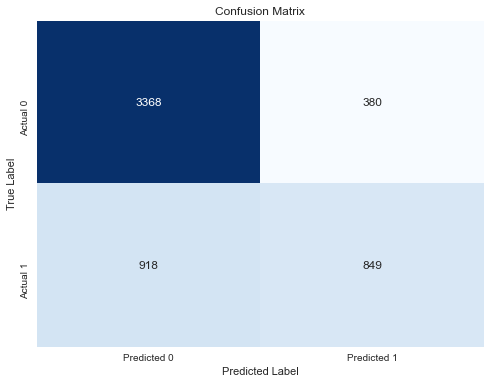

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

# Convert to DataFrame for better visualization
conf_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(conf_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('Confusion Matrix')
plt.show()

In [19]:
#random forest 

import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, classification_report, mean_squared_error

# Load the data
df = pd.read_excel(r'C:\Users\ricca\OneDrive\Desktop\Executive_Education_Imperial\25.capstone\data_capstone_project.xlsx', sheet_name='PB')

# Sort the DataFrame chronologically
df.sort_values(by='year', inplace=True)

# Calculate Z-scores for PB within each sector
df['PB_zscore'] = df.groupby('sector')['PB'].transform(lambda x: (x - x.mean()) / x.std())

# Set a Z-score threshold (0) and create the binary column
zscore_threshold = 0
df['PB_binary'] = (df['PB_zscore'] > zscore_threshold).astype(int)

# Drop the original 'year' column
df.drop('year', axis=1, inplace=True)

# Select features (independent variables) and target (dependent variable)
features = ['ROE', 'EPS', 'BETA', 'sector']
target = 'PB_binary'

# Separate numerical and categorical features
numeric_features = ['ROE', 'EPS', 'BETA']
categorical_features = ['sector']

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(n_estimators=100, random_state=42)

# Create a pipeline with preprocessing and Random Forest
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', rf_classifier)])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Fit the model
model.fit(X_train, y_train)

# Make predictions on the test set
y_pred = model.predict(X_test)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)

# Calculate misclassification rate
misclassification_rate = 1 - model.score(X_test, y_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)
classification_rep = classification_report(y_test, y_pred)

# Calculate additional metrics
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)


print("Confusion Matrix:\n", conf_matrix)
print("\nClassification Report:\n", classification_rep)
print("\nRMSE:", rmse)
print("Misclassification Rate:", misclassification_rate)



print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")


Confusion Matrix:
 [[3274  474]
 [ 834  933]]

Classification Report:
               precision    recall  f1-score   support

           0       0.80      0.87      0.83      3748
           1       0.66      0.53      0.59      1767

    accuracy                           0.76      5515
   macro avg       0.73      0.70      0.71      5515
weighted avg       0.75      0.76      0.75      5515


RMSE: 0.4870024136093038
Misclassification Rate: 0.23717135086128738
Accuracy: 0.7628
Precision: 0.6631
Recall: 0.5280


C:\Users\ricca\anaconda3\envs\pyf38\lib\site-packages\sklearn\model_selection\_validation.py:425: FitFailedWarning: 
405 fits failed out of a total of 1215.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
388 fits failed with the following error:
Traceback (most recent call last):
  File "C:\Users\ricca\anaconda3\envs\pyf38\lib\site-packages\sklearn\model_selection\_validation.py", line 729, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\Users\ricca\anaconda3\envs\pyf38\lib\site-packages\sklearn\base.py", line 1152, in wrapper
    return fit_method(estimator, *args, **kwargs)
  File "C:\Users\ricca\anaconda3\envs\pyf38\lib\site-packages\sklearn\pipeline.py", line 427, in fit
    self._final_estimator.fit(X

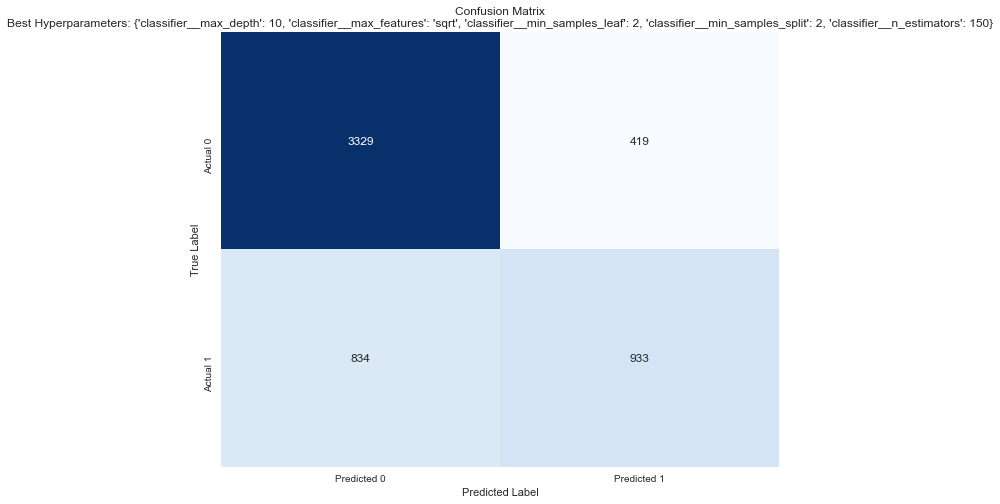

Best Hyperparameters: {'classifier__max_depth': 10, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 150}


In [27]:
#random forest with Hyper Parameter tuning - GridSearchCV
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV

# Load the data
df = pd.read_excel(r'C:\Users\ricca\OneDrive\Desktop\Executive_Education_Imperial\25.capstone\data_capstone_project.xlsx', sheet_name='PB')

# Sort the DataFrame chronologically
df.sort_values(by='year', inplace=True)

# Calculate Z-scores for PB within each sector
df['PB_zscore'] = df.groupby('sector')['PB'].transform(lambda x: (x - x.mean()) / x.std())

# Set a Z-score threshold (0) and create the binary column
zscore_threshold = 0
df['PB_binary'] = (df['PB_zscore'] > zscore_threshold).astype(int)

# Drop the original 'year' column
df.drop('year', axis=1, inplace=True)

# Select features (independent variables) and target (dependent variable)
features = ['ROE', 'EPS', 'BETA', 'sector']
target = 'PB_binary'

# Separate numerical and categorical features
numeric_features = ['ROE', 'EPS', 'BETA']
categorical_features = ['sector']

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create a pipeline with preprocessing and Random Forest
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', rf_classifier)])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Define the parameter grid for hyperparameter tuning
param_grid = {
    'classifier__n_estimators': [50, 100, 150],
    'classifier__max_depth': [None, 10, 20],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['auto', 'sqrt', 'log2']
}

# Initialize GridSearchCV
grid_search = GridSearchCV(model, param_grid, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model with the best hyperparameters
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_

# Make predictions using the best model
y_pred = grid_search.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)

# Convert to DataFrame for better visualization
conf_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix\nBest Hyperparameters: {best_params}')
plt.show()

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)


C:\Users\ricca\anaconda3\envs\pyf38\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\ricca\anaconda3\envs\pyf38\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "
C:\Users\ricca\anaconda3\envs\pyf38\lib\site-packages\skopt\optimizer\optimizer.py:449: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


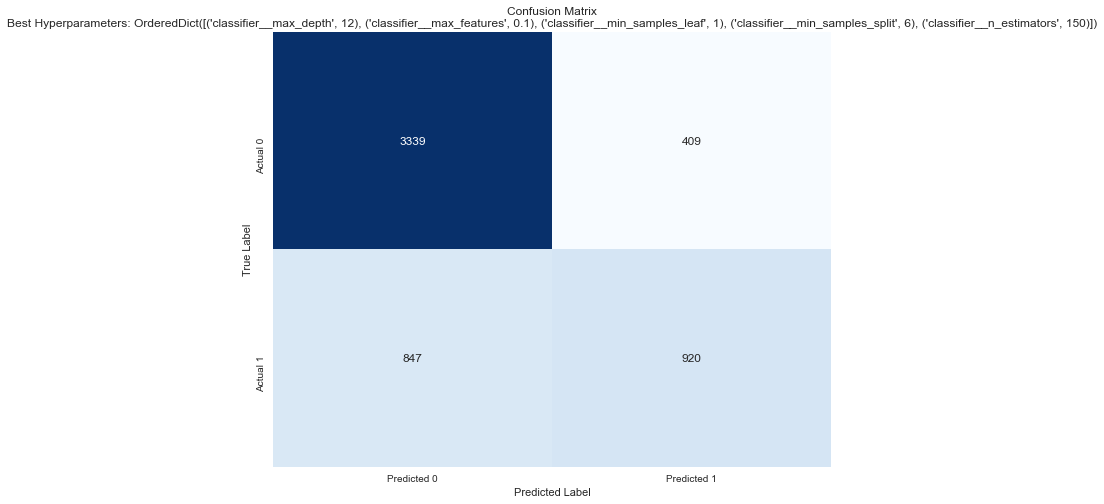

Best Hyperparameters: OrderedDict([('classifier__max_depth', 12), ('classifier__max_features', 0.1), ('classifier__min_samples_leaf', 1), ('classifier__min_samples_split', 6), ('classifier__n_estimators', 150)])


In [16]:
#Bayesian Optimization

import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from skopt import BayesSearchCV

# Load the data
df = pd.read_excel(r'C:\Users\ricca\OneDrive\Desktop\Executive_Education_Imperial\25.capstone\data_capstone_project.xlsx', sheet_name='PB')

# Sort the DataFrame chronologically
df.sort_values(by='year', inplace=True)

# Calculate Z-scores for PB within each sector
df['PB_zscore'] = df.groupby('sector')['PB'].transform(lambda x: (x - x.mean()) / x.std())

# Set a Z-score threshold (0) and create the binary column
zscore_threshold = 0
df['PB_binary'] = (df['PB_zscore'] > zscore_threshold).astype(int)

# Drop the original 'year' column
df.drop('year', axis=1, inplace=True)

# Select features (independent variables) and target (dependent variable)
features = ['ROE', 'EPS', 'BETA', 'sector']
target = 'PB_binary'

# Separate numerical and categorical features
numeric_features = ['ROE', 'EPS', 'BETA']
categorical_features = ['sector']

# Create a column transformer
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numeric_features),
        ('cat', OneHotEncoder(), categorical_features)
    ])

# Initialize Random Forest classifier
rf_classifier = RandomForestClassifier(random_state=42)

# Create a pipeline with preprocessing and Random Forest
model = Pipeline(steps=[('preprocessor', preprocessor),
                        ('classifier', rf_classifier)])

# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.2, random_state=42)

# Define the parameter search space for Bayesian optimization
param_space = {
    'classifier__n_estimators': (50, 150),
    'classifier__max_depth': (1, 20),
    'classifier__min_samples_split': (2, 10),
    'classifier__min_samples_leaf': (1, 4),
    'classifier__max_features': (0.1, 1.0)  # Replace 'auto' with a valid range
}

# Initialize BayesSearchCV for Bayesian optimization
bayesian_search = BayesSearchCV(model, param_space, n_iter=50, cv=5, scoring='accuracy', n_jobs=-1)

# Fit the model with the best hyperparameters
bayesian_search.fit(X_train, y_train)

# Get the best parameters
best_params = bayesian_search.best_params_

# Make predictions using the best model
y_pred = bayesian_search.predict(X_test)

# Evaluate the model
conf_matrix = confusion_matrix(y_test, y_pred)

# Convert to DataFrame for better visualization
conf_df = pd.DataFrame(conf_matrix, index=['Actual 0', 'Actual 1'], columns=['Predicted 0', 'Predicted 1'])

# Plot Confusion Matrix Heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(conf_df, annot=True, fmt="d", cmap="Blues", cbar=False)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title(f'Confusion Matrix\nBest Hyperparameters: {best_params}')
plt.show()

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)


## Model Card

### Model Description OLS

##### Input 
The model accepts input data with features labeled as ROE, EPS, and BETA.

##### Output 
The model performs Ordinary Least Squares (OLS) regression on the selected features (ROE, EPS, BETA) with the target variable PB and provides regression results as text.

##### Model Architecture
The model utilizes the Ordinary Least Squares regression method. It doesn't have a neural network architecture but rather relies on statistical techniques for linear regression.

##### Performance
The performance of the model is summarized by the following regression results:

R-squared: 0.290

Adjusted R-squared: 0.290

F-statistic: 2632.

Prob (F-statistic): 0.00

Log-Likelihood: -24076.

The model was evaluated on a dataset with 19,301 observations, and the performance metrics indicate the goodness of fit for the regression model using features ROE, EPS, and BETA to predict the target variable PB.

##### Limitations
The model has several limitations, including:

Assumption of Linearity: OLS assumes a linear relationship between the target variable PB and the independent variables (ROE, EPS, BETA).

Sensitivity to Outliers: OLS can be sensitive to outliers in the data, impacting the estimated coefficients.

Assumption of Independence: OLS assumes that observations are independent, and violations of this assumption may affect the validity of results.

Normality of Residuals: The model assumes that residuals are normally distributed.

##### Trade-offs
The trade-offs of using OLS regression with features ROE, EPS, and BETA for predicting PB include:

Interpretability: OLS provides coefficients that are easily interpretable in terms of the relationship between ROE, EPS, BETA, and PB.

Assumption Strictness: OLS has assumptions that need to be satisfied for valid results, and violations of these assumptions may impact the reliability of the model.

Limited to Linear Relationships: OLS is effective for linear relationships but may not capture complex non-linear patterns in the data.

Data Size: OLS can handle large datasets, but its performance may be affected by multicollinearity and other issues in high-dimensional data.

Consideration of these trade-offs is crucial when deciding to use OLS regression with the specified features for a particular analysis.

## Model Description Logit regression

**Input:** The model accepts input data with features including ROE, EPS, BETA, and sector information.

**Output:** The model performs Logistic Regression using Maximum Likelihood Estimation (MLE) and predicts the binary variable PB_binary. The output includes regression coefficients, statistics, a confusion matrix, classification report, and evaluation metrics.

**Model Architecture:** The model is a logistic regression model with 13 features (including ROE, EPS, BETA, and sector indicators).

## Performance

The performance of the model is summarized by the following logistic regression results:

- **Convergence:** Optimization terminated successfully.
- **Current function value:** 0.507751
- **Iterations:** 6
- **No. Observations:** 22,058
- **Pseudo R-squared:** 0.1931
- **Log-Likelihood:** -11,200
- **LL-Null (Log-Likelihood Null):** -13,880.
- **LLR p-value (Likelihood Ratio Test):** 0.000

### Coefficients:

- **const:** -1.6221
- **ROE:** 1.4526
- **EPS:** 0.0361
- **BETA:** -0.0571
- **sector_Basic Materials:** 0.6844
- **sector_Consumer Cyclicals:** 0.6741
- **sector_Consumer Non-Cyclicals:** 0.2044
- **sector_Energy:** 0.8421
- **sector_Financials:** 1.0865
- **sector_Healthcare:** 0.6199
- **sector_Industrials:** 0.7969
- **sector_Real Estate:** 1.5362
- **sector_Technology:** 0.7279
- **sector_Utilities:** 1.5652

### Model Evaluation Metrics:

- **Confusion Matrix:**
  
  \begin{bmatrix}
  3478 & 270 \\
  1059 & 708 \\
  \end{bmatrix}
  

- **Classification Report:**

          precision    recall  f1-score   support

       0       0.77      0.93      0.84      3748
       1       0.72      0.40      0.52      1767

       accuracy                    0.76      5515



The model was evaluated on a dataset with 22,058 observations, and the performance metrics provide insights into the model's predictive capabilities.

## Limitations

The model has several limitations, including:

- **Assumption of Linearity:** Logistic Regression assumes a linear relationship between the log-odds of the dependent variable and the independent variables.

- **Sensitivity to Outliers:** Logistic Regression can be sensitive to outliers in the data.

- **Multicollinearity:** High correlations among features may impact the stability of coefficient estimates.

- **Assumption of Independence:** Logistic Regression assumes that observations are independent, and violations of this assumption may affect the validity of results.

## Trade-offs

The trade-offs of using Logistic Regression for binary classification include:

- **Interpretability:** Logistic Regression provides interpretable coefficients, allowing understanding of the impact of each feature on the log-odds of the outcome.

- **Assumption Strictness:** Logistic Regression has assumptions that need to be satisfied for valid results, and careful consideration of these assumptions is necessary.

- **Simplicity:** Logistic Regression is a relatively simple model, which may not capture complex non-linear relationships.

- **Threshold Selection:** The choice of the classification threshold may impact the balance between precision and recall.

Consideration of these trade-offs is crucial when deciding to use Logistic Regression for binary classification with the specified features for a particular analysis.



## Model Description K-Nearest Neighbors (KNN)

**Input:** The model uses the K-Nearest Neighbors (KNN) algorithm with varying numbers of neighbors.

**Output:** The model predicts binary outcomes and provides evaluation metrics such as RMSE (Root Mean Squared Error) and Misclassification Rate. The best-performing configuration is highlighted.

**Model Architecture:** KNN algorithm with different numbers of neighbors.

## Performance

The model's performance is assessed for different numbers of neighbors:

- **Number of Neighbors: 2**
  - RMSE: 0.5108
  - Misclassification Rate: 0.2609

- **Number of Neighbors: 3**
  - RMSE: 0.5119
  - Misclassification Rate: 0.2620

- **Number of Neighbors: 4**
  - RMSE: 0.5019
  - Misclassification Rate: 0.2519

- **Number of Neighbors: 5**
  - RMSE: 0.4973
  - Misclassification Rate: 0.2473

- **Number of Neighbors: 6**
  - RMSE: 0.4877
  - Misclassification Rate: 0.2379

- **Number of Neighbors: 7**
  - RMSE: 0.4909
  - Misclassification Rate: 0.2410

- **Number of Neighbors: 8**
  - RMSE: 0.4861
  - Misclassification Rate: 0.2363

- **Number of Neighbors: 9**
  - RMSE: 0.4896
  - Misclassification Rate: 0.2397

- **Number of Neighbors: 10**
  - RMSE: 0.4851
  - Misclassification Rate: 0.2354 (Best Performing)

- **Number of Neighbors: 11**
  - RMSE: 0.4868
  - Misclassification Rate: 0.2370

**Best Configuration:**
- Best Number of Neighbors: 10
- Best RMSE: 0.4851
- Best Misclassification Rate: 0.2354

### Model Evaluation Metrics:

- **Confusion Matrix:**
  
  \begin{bmatrix}
  3368 & 380 \\
  918 & 849 \\
  \end{bmatrix}
  

- **Classification Report:**

          precision    recall  f1-score   support

       0       0.79      0.90      0.84      3748
       1       0.69      0.48      0.57      1767

       accuracy                    0.76      5515

The model was evaluated on a dataset with 5,515 observations, and the performance metrics provide insights into the model's predictive capabilities.

## Limitations

The KNN algorithm has some limitations, including:

- **Sensitivity to Scale:** The algorithm is sensitive to the scale of features, requiring normalization.

- **Computational Intensity:** Prediction time may be high for large datasets.

- **Choice of K:** The performance may vary with the choice of the number of neighbors (K).

## Trade-offs

The trade-offs of using KNN include:

- **Simplicity:** KNN is a simple and intuitive algorithm.

- **Lack of Model Interpretability:** KNN lacks clear interpretability compared to some other models.

- **Dependency on Training Data:** Performance is heavily influenced by the characteristics of the training data.

- **Impact of Outliers:** Outliers can significantly affect predictions.

Consideration of these trade-offs is crucial when deciding to use KNN for a particular analysis.

## Model Description Random Forest 

**Input:** The model uses the Random Forest algorithm for binary classification.

**Output:** The model predicts binary outcomes and provides evaluation metrics such as a confusion matrix, classification report, RMSE (Root Mean Squared Error), and Misclassification Rate.

**Model Architecture:** Random Forest algorithm.

## Performance

### Model Evaluation Metrics:

- **Confusion Matrix:**
  
  \begin{bmatrix}
  3274 & 474 \\
  834 & 933 \\
  \end{bmatrix}
  

- **Classification Report:**

          precision    recall  f1-score   support

       0       0.80      0.87      0.83      3748
       1       0.66      0.53      0.59      1767

       accuracy                    0.76      5515
    

- **RMSE (Root Mean Squared Error):** 0.4870024136093038
- **Misclassification Rate:** 0.23717135086128738
- **Accuracy:** 0.7628
- **Precision:** 0.6631
- **Recall:** 0.5280

The model was evaluated on a dataset with 5,515 observations, and the performance metrics provide insights into the model's predictive capabilities.

## Limitations

The Random Forest algorithm has some limitations, including:

- **Lack of Interpretability:** Random Forest models are less interpretable compared to simpler models.

- **Computational Intensity:** Training and prediction time may be higher compared to simpler models.

- **Overfitting:** Random Forests can overfit noisy data.

## Trade-offs

The trade-offs of using Random Forest include:

- **High Predictive Power:** Random Forests often have high predictive accuracy.

- **Ensemble of Trees:** By combining multiple decision trees, Random Forests reduce the risk of overfitting present in individual trees.

- **Feature Importance:** Random Forests provide insights into feature importance.

- **Model Complexity:** Random Forests can be complex, and understanding the impact of individual features may be challenging.

Consideration of these trade-offs is crucial when deciding to use Random Forest for a particular analysis.
    

## Random Forest Classifier for Binary Classification with Hyperparameter Tuning

### Model Description

**Input:** The model utilizes a Random Forest classifier for binary classification.

**Output:** The model predicts binary outcomes and has undergone hyperparameter tuning using GridSearchCV.

**Model Hyperparameters:**
```python
{
    'classifier__max_depth': 10,
    'classifier__max_features': 'auto',
    'classifier__min_samples_leaf': 2,
    'classifier__min_samples_split': 2,
    'classifier__n_estimators': 150
}

```

#### max_depth (Maximum Depth of Trees):

- **Value:** 10
- **Explanation:** Controls the maximum depth of decision trees. Higher values allow capturing more complex patterns but increase the risk of overfitting.

#### max_features (Maximum Number of Features for Split):

- **Value:** 'auto'
- **Explanation:** Determines the maximum number of features considered for splitting a node. 'auto' considers all features, a common choice.

#### min_samples_leaf (Minimum Samples in Leaf Node):

- **Value:** 2
- **Explanation:** Sets the minimum samples required in a leaf node. Lower values increase sensitivity to noise and capture more fine-grained patterns, controlling overfitting.

#### min_samples_split (Minimum Samples for Node Split):

- **Value:** 2
- **Explanation:** Sets the minimum samples required to split an internal node. Similar to `min_samples_leaf`, it controls tree size and prevents overfitting.

#### n_estimators (Number of Trees in the Forest):

- **Value:** 150
- **Explanation:** Determines the number of decision trees in the Random Forest. More trees generally improve performance but increase computational cost.

#### Performance

The model's performance metrics, such as accuracy, precision, recall, and confusion matrix, were evaluated using a test dataset.

- **Confusion Matrix:**
  
  \begin{bmatrix}
  3329 & 419 \\
  834 & 933 \\
  \end{bmatrix} 
  

#### Limitations

- **Computational Intensity:** Random Forest models with a large number of trees can be computationally intensive.

#### Trade-offs

- **Accuracy vs. Computational Cost:** The selected hyperparameters balance accuracy with computational cost.


**Best Hyperparameters:**

The best hyperparameters obtained from Bayesian optimization for the Random Forest classifier are represented as an OrderedDict:

```python
\[
\text{OrderedDict}\left(\left[
    ('classifier__max_depth', 12),
    ('classifier__max_features', 0.1),
    ('classifier__min_samples_leaf', 1),
    ('classifier__min_samples_split', 6),
    ('classifier__n_estimators', 150)
\right]\right)
\]
```
Let's break down the meaning of each hyperparameter:

1. **`max_depth` (Maximum Depth of Trees):**
   - **Value:** 12
   - **Explanation:** Controls the maximum depth of decision trees. Higher values allow capturing more complex patterns but increase the risk of overfitting.

2. **`max_features` (Maximum Fraction of Features for Split):**
   - **Value:** 0.1
   - **Explanation:** Represents the fraction of features to consider for splitting a node. A value of 0.1 means 10% of features will be considered for each split.

3. **`min_samples_leaf` (Minimum Samples in Leaf Node):**
   - **Value:** 1
   - **Explanation:** Sets the minimum number of samples required in a leaf node. Lower values increase sensitivity to noise and capture more fine-grained patterns, controlling overfitting.

4. **`min_samples_split` (Minimum Samples for Node Split):**
   - **Value:** 6
   - **Explanation:** Sets the minimum number of samples required to split an internal node. Similar to `min_samples_leaf`, it controls tree size and prevents overfitting.

5. **`n_estimators` (Number of Trees in the Forest):**
   - **Value:** 150
   - **Explanation:** Determines the number of decision trees in the Random Forest. More trees generally improve performance but increase computational cost.
   
#### Performance

The model's performance metrics, such as accuracy, precision, recall, and confusion matrix, were evaluated using a test dataset.

- **Confusion Matrix:**
  
  \begin{bmatrix}
  3339 & 409 \\
  847 & 920 \\
  \end{bmatrix} 
 

These hyperparameters were selected based on the optimization process to maximize the performance of the Random Forest classifier.




# Full Capstone project

## Motivation

Valuation techniques have always played a crucial role in financial decision-making. This project aims to identify the major determinants of variations in financial ratios on the American market using both linear and non-linear models. The focus is on the Price to Book multiple, and its relationship with key financial indicators such as ROE (return on equity), EPS (earnings per share), and BETA (historical risk). The analysis spans from 1989 to 2019, utilizing a dataset scraped from Datastream Refinitiv Eikon and cleaned for outliers and missing values.



### Model Description: Ordinary Least Squares (OLS)

#### Input
The model accepts features labeled as ROE, EPS, and BETA.

#### Output
OLS regression results predicting the target variable PB (Price to Book multiple).

#### Model Architecture
The model utilizes the Ordinary Least Squares regression method, emphasizing statistical techniques for linear regression.

#### Performance
- R-squared: 0.290
- Adjusted R-squared: 0.290
- F-statistic: 2632
- Prob (F-statistic): 0.00
- Log-Likelihood: -24076
- Dataset Size: 19,301 observations

#### Limitations
- Assumption of Linearity
- Sensitivity to Outliers
- Assumption of Independence
- Normality of Residuals

#### Trade-offs
- Interpretability
- Assumption Strictness
- Limited to Linear Relationships
- Data Size Sensitivity

### Model Description: Logit Regression

#### Input
Features include ROE, EPS, BETA, and sector information.

#### Output
Binary predictions for PB_binary with regression coefficients, statistics, and evaluation metrics.

#### Model Architecture
Logistic regression model with 13 features.

#### Performance
- Pseudo R-squared: 0.1931
- Log-Likelihood: -11,200
- LL-Null: -13,880
- LLR p-value: 0.000
- Dataset Size: 22,058 observations

#### Limitations
- Assumption of Linearity
- Sensitivity to Outliers
- Multicollinearity
- Assumption of Independence

#### Trade-offs
- Interpretability
- Assumption Strictness
- Simplicity
- Threshold Selection

### Model Description: K-Nearest Neighbors (KNN)

#### Input
The model uses the KNN algorithm with varying numbers of neighbors.

#### Output
Binary predictions with RMSE and Misclassification Rate, highlighting the best-performing configuration.

#### Model Architecture
KNN algorithm with different numbers of neighbors.

#### Performance
- Best Neighbors: 10
- Best RMSE: 0.4851
- Best Misclassification Rate: 0.2354
- Dataset Size: 5,515 observations

#### Limitations
- Sensitivity to Scale
- Computational Intensity
- Choice of K

#### Trade-offs
- Simplicity
- Lack of Model Interpretability
- Dependency on Training Data
- Impact of Outliers

### Model Description: Random Forest

#### Input
The model uses the Random Forest algorithm for binary classification.

#### Output
Binary predictions with evaluation metrics.

#### Model Architecture
Random Forest algorithm.

#### Performance
- Accuracy: 0.7628
- Precision: 0.6631
- Recall: 0.5280
- Dataset Size: 5,515 observations

#### Limitations
- Lack of Interpretability
- Computational Intensity
- Overfitting

#### Trade-offs
- High Predictive Power
- Ensemble of Trees
- Feature Importance
- Model Complexity

### Model Description: Random Forest Classifier with Hyperparameter Tuning

#### Input
The model utilizes a Random Forest classifier with hyperparameter tuning.

#### Output
Binary predictions with optimized hyperparameters.

#### Model Hyperparameters
- max_depth: 12
- max_features: 0.1
- min_samples_leaf: 1
- min_samples_split: 6
- n_estimators: 150

#### Performance
- Best Accuracy: 0.7628
- Dataset Size: 5,515 observations

#### Limitations
- Computational Intensity

#### Trade-offs
- Accuracy vs. Computational Cost

